# Section 2 Project (작성자 : 계윤우)


## 1. 주제 : 어떤 주식을 사야 미래에 오를까?
## 2. 목표 : 내가 고른 주식의 데이터를 넣었을 때, 해당 주식이 미래에 코스피 지수보다 더 오를지, 덜 오를지 '분류'하는 모델 만들기
- 모델 종류 : 이진 분류
- Target
    - 0 : 고른 종목(데이터)이 6개월 뒤 KOSPI보다 낮은 수익률을 보였다.
    - 1 : 고른 종목이 6개월 뒤 KOSPI보다 높은 수익률을 보였다.
    
    
## 3. 데이터
- 분석 종목 : 2003년 기준 시가총액 상위 400위 기업(데이터 누수를 피하기 위해 현재 기준으로 하지 않음)
- 종류  
    1) 시가총액 데이터 : 한국거래소  
    2) 주가 변동 데이터 : 2003년 ~ 현재, `FinanceDataReader` 라이브러리 사용  
    3) 종목에 따른 연도별 PER, PBR, 배당수익률 데이터 : 한국거래소
    
## 4. Feature
- 미래의 주가에 영향을 끼칠 것이라 예상되는 것들로 선정
- 종류  
    1) 12개월 간 수익률 : 최근 12개월 간 수익률이 얼마나 났는가 (float)  
    2) KOSPI대비 12개월 간 수익률 : 최근 12개월 간 KOSPI 대비 수익률이 얼마나 났는가 (float)  
    3) 12개월 간 KOSPI 이김 : 최근 12개월 간 KOSPI 대비 수익률이 높았는가 (binary)  
    4) PER_inv : 해당 종목, 해당 시점의 PER의 역수(float)  
    5) PBR_inv : 해당 종목, 해당 시점의 PBR의 역수(float)  
    6) 배당수익률 : 주주에게 배분된 배당금과 주주가 갖고 있는 주식 가치의 비  
    
 (* PER, PBR은 시가총액과 당기순이익, 자본의 비이며 낮을 수록 저평가된 기업으로 여겨짐)
 
 
 ## 5. 가설
 - Feature와 Target 사이에는 시간에 독립적인 관계가 있다.
 - 따라서 시간에 관계 없이 종목의 feature, target 데이터만 있으면 모델을 학습시키고, 결과를 예측할 수 있다.

# 1. 데이터 수집
- 2003년 기준 시가총액 상위 400 종목에 대해 2003년부터 현재까지 주가 변동 및 
- 2010년 기준 시가총액 상위 N 종목

In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import FinanceDataReader as fdr
import dart_fss as dart
import warnings
from datetime import datetime, timedelta
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import f1_score, plot_confusion_matrix, roc_curve, roc_auc_score, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

import eli5
from eli5.sklearn import PermutationImportance


warnings.filterwarnings(action='ignore')
%matplotlib inline
mpl.rc("font", family='Malgun Gothic')
plt.style.use('ggplot')
pd.options.display.max_rows = 500

In [151]:
# 2003년부터 PER, PBR이 기입돼 있어서 2003년부터
date_list = ['20030102', '20040102', '20050102', '20060102', '20070102', '20080102', '20090102'
             , '20110102', '20120102', '20130102', '20140102', '20150102'
             , '20160102', '20170102', '20180102', '20190102', '20200102']

date_list_for_PER = date_list + ['20210102']

date_start = date_list[0]

N = 600 # 시가총액 상위 N 종목

df = pd.read_csv('./data/{}_total_stock.csv'.format(date_start), encoding='euc-kr')

# 시가총액 상위 N종목 코드 리스트
top_code = df.sort_values(by='시가총액', ascending=False).head(N).종목코드.to_list()

# 종목코드를 가지고 종목명을 찾을 수 있는 dictionary
code_to_name_dic = df[['종목코드', '종목명']].set_index('종목코드').to_dict()['종목명']

KOSPI = fdr.DataReader('KS11', date_start)

# 종목코드별 주가 데이터 dictionary에 저장
stock_price_dic = {}
for code in top_code:
    stock_price_dic[code] = fdr.DataReader(code, date_start)

# 2. 데이터 가공하기 및 엔지니어링

In [186]:
def date_add(date, month):
    '''date에 month만큼 더해준다. date는 20210102와 같은 꼴이나 datetime type으로 입력한다.'''
    if type(date) == str: # date가 datetime이 아니라 str 타입으로 들어온 경우
        date = datetime.strptime(date, '%Y%m%d')
    delta = timedelta(days=month*30.5)
    return date + delta

print('date_add 함수 테스트 : {}'.format(date_add(date_start, 12)))


def earning_rate(stock_price : list, start_date, end_date):
    '''start_date부터 end_date까지 stock_price데이터를 가지고 수익률을 구해주는 함수(종가 기준)'''
    possible_start_date = stock_price[stock_price.index >= start_date].index[0]
    possible_end_date = stock_price[stock_price.index <= end_date].index[-1]
    
    start_price = stock_price.loc[possible_start_date].Close
    end_price = stock_price.loc[possible_end_date].Close
    
    return (end_price - start_price) / start_price
    
sample_stock_price = stock_price_dic[top_code[0]]

print('수익률 함수 테스트 : {:.4f}%'.format(earning_rate(sample_stock_price, '20170101', '20170603')*100))


def plot_stock(stock_price_dic : dict, code : str) -> None :
    '''stock_price_dic과 종목 code를 받으면 주가 변동을 그려주는 함수(종가 기준)'''
    plt.plot(stock_price_dic[code].Close)
    plt.xlabel('date')
    plt.ylabel('원')
    plt.title(code_to_name_dic[code])

date_add 함수 테스트 : 2004-01-03 00:00:00
수익률 함수 테스트 : 27.3130%


1위


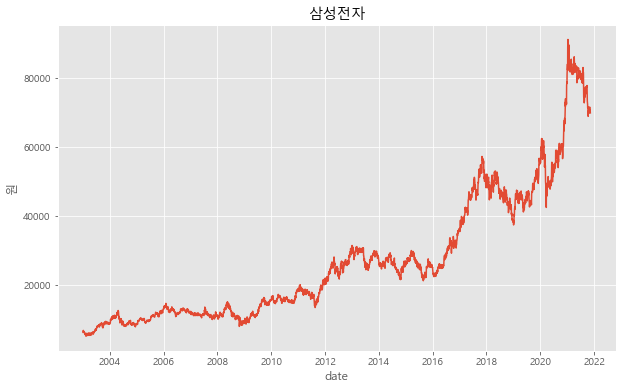

2위


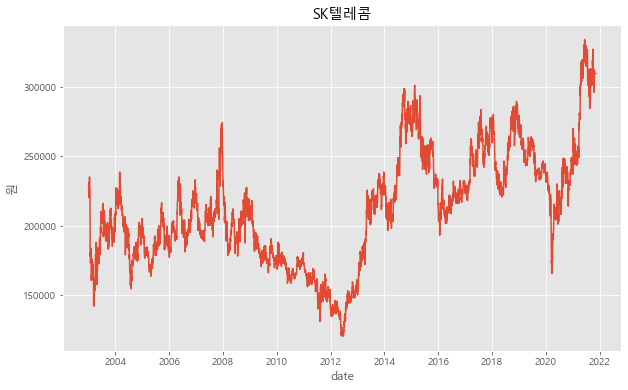

3위


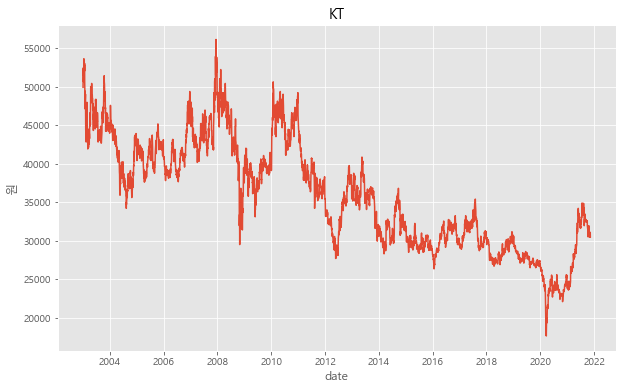

4위


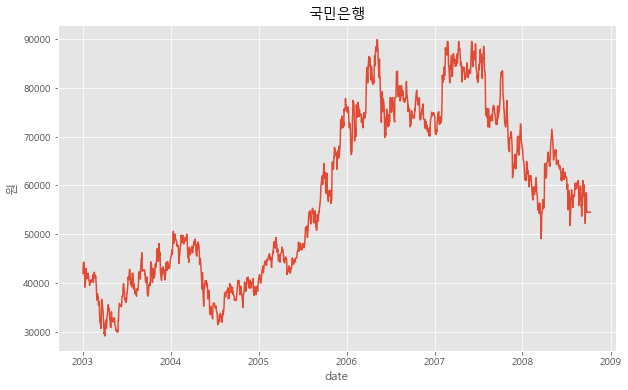

5위


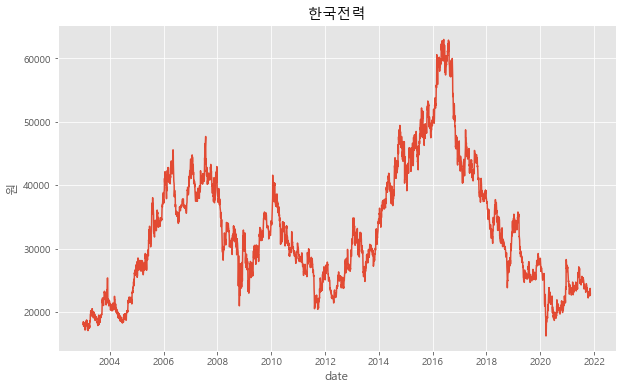

In [187]:
for i, code in enumerate(top_code[:5]):
    plt.figure(figsize=(10,6))
    plot_stock(stock_price_dic, code)
    print('{}위'.format(i+1))
    plt.show()

In [188]:
stock_price = stock_price_dic[top_code[0]]
stock_price.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2003-01-02,6380,6460,6300,6430,511660,0.023885
2003-01-03,6700,7000,6640,6880,1110675,0.069984
2003-01-06,6940,7030,6879,6990,499437,0.015988
2003-01-07,7180,7180,6840,6850,577944,-0.020029
2003-01-08,6920,6930,6770,6800,504232,-0.007299


In [313]:
n = 12 # n개월 간의 주가 추이 확인
m = 6 # m개월 후의 수익률 확인

def ER_list_return(stock_price, n=n, m=m, date_list=date_list):
    '''stock_price정보를 가지고 base_date 기준 n개월 전, m개월 후 수익률(Earning Rate)을 구해준다.
    return : 데이터로 사용할 수익률, target을 구할 때 사용할 수익률, base_date'''
    earning_rate_list = []
    target_list = []
    base_date_list = []  # 수익률 기준일
    
    periods = 12//n # n = 2개월이면 12개월을 6개로 쪼개는 식
    for date in date_list:
        try:
            for period in range(periods): 
                date_start = date_add(date, period*n)
                date_end = date_add(date_start, n)
                
                ER_before = earning_rate(stock_price, date_start, date_end)
                ER_after = earning_rate(stock_price, date_end, date_add(date_end, m))
                
                earning_rate_list.append(ER_before)
                target_list.append(ER_after)
                base_date_list.append(date_end)
                
        except: # 종목코드가 바뀌거나 상장폐지돼서 주가 데이터가 없는 경우가 있는 것 같음. 이를 고려             
            break

    return earning_rate_list, target_list, base_date_list


# DataFrame 만들기 위해 모든 종목들에 대해 시행해주기
n_month_ER_data = []
m_month_ER_data = []
date_data = []
code_data = []

for code in top_code:
    stock_price = stock_price_dic[code]
    earning_rate_list, target_list, base_date_list = ER_list_return(stock_price)
    n_month_ER_data += earning_rate_list
    m_month_ER_data += target_list
    date_data += base_date_list
    code_data += [code]*len(base_date_list)

In [386]:
data = pd.DataFrame({
                     'date' : date_data,
                     'code' : code_data,
                     f'{n}개월 간 수익률': n_month_ER_data,
                     f'{m}개월 후 수익률' : m_month_ER_data
                    })

data['name'] = data.code.apply(lambda x: code_to_name_dic[x])

KOSPI_n_earning, KOSPI_m_earning, KOSPI_base_date = ER_list_return(KOSPI)

KOSPI_data = pd.DataFrame({
                     'date' : KOSPI_base_date,
                     f'KOSPI {n}개월 간 수익률': KOSPI_n_earning,
                     f'KOSPI {m}개월 후 수익률' : KOSPI_m_earning
                    })

data = data.merge(KOSPI_data, on='date')

# KOSPI 대비 수입률 Feature 만들기
data[f'KOSPI대비 {n}개월 간 수익률'] = data[f'{n}개월 간 수익률'] - data[f'KOSPI {n}개월 간 수익률']
data[f'KOSPI대비 {m}개월 후 수익률'] = data[f'{m}개월 후 수익률'] - data[f'KOSPI {m}개월 후 수익률']
data[f'{n}개월 간 KOSPI 이김'] = data[f'KOSPI대비 {n}개월 간 수익률'].apply(lambda x: 1 if x>=0 else 0)
data[f'KOSPI보다 많이 오름'] = data[f'KOSPI대비 {m}개월 후 수익률'].apply(lambda x: 1 if x>=0 else 0)



# PER 파일 불러와서 dic에 저장
df_PER_dic = {}
for date in date_list_for_PER:
    # 결측치는 0으로
    df_PER_dic[date] = pd.read_csv('./data/{}_PER_PBR.csv'.format(date), encoding='euc-kr')
    df_PER_dic[date][['PER', 'PBR']] = df_PER_dic[date][['PER', 'PBR']].fillna(10000)
    df_PER_dic[date][['배당수익률']] = df_PER_dic[date][['배당수익률']].fillna(0)

def near_date_for_PER(date, date_list=date_list_for_PER):
    '''한국거래소에서 받은 PER를 데이터 누수(미래의 PER 사용;) 없이 사용하기 위해 date에 따라 적절한 사용가능 날짜를 date_list에서 뽑아 리턴.
    date는 datetime 타입'''
    for d in date_list:
        d = datetime.strptime(d, '%Y%m%d')
        if d - timedelta(days=30) <= date < d + timedelta(days=336):
            return d.strftime('%Y%m%d')
    return date_list[0]

# near_date_for_PER(data.date[0])

def search_for_PER(code, date):
    '''code와 date 조건에 맞는 데이터를 PER가 담긴 df에서 찾아줌'''
    if type(date) != str:
        date = near_date_for_PER(date)
    df = df_PER_dic[date]
    cond = df['종목코드'] == code
    
    if cond.sum() == 0:
        fake_data = [0] * len(df.columns)
        return pd.DataFrame([fake_data], columns=df.columns)
    return df[cond]

# search_for_PER('069117', '20110102')

temp_df_list = []
for date, code in zip(data.date, data.code):
    temp_df_list.append(search_for_PER(code, date))
data_PER = pd.concat(temp_df_list, ignore_index=True)

data = pd.concat([ data, data_PER[['PER', 'PBR', '배당수익률']] ], axis=1)
data['PER_inv'] = 1/data['PER']
data['PBR_inv'] = 1/data['PBR']

data.head(3)

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
0,2004-01-03,005930,0.396579,-0.029508,삼성전자,0.292977,-0.083339,0.103602,0.053831,1,1,10.69,2.83,1.22,0.093545,0.353357
1,2004-01-03,017670,-0.066667,-0.122302,SK텔레콤,0.292977,-0.083339,-0.359643,-0.038963,0,0,11.71,2.14,0.86,0.085397,0.467290
2,2004-01-03,030200,-0.092184,-0.166667,KT,0.292977,-0.083339,-0.385161,-0.083327,0,0,5.98,1.01,1.90,0.167224,0.990099


In [315]:
data.shape

(8267, 16)

# 3. 모델링 및 예측

In [316]:
features = [f'{n}개월 간 수익률', f'KOSPI대비 {n}개월 간 수익률', f'{n}개월 간 KOSPI 이김', 'PER_inv', 'PBR_inv', '배당수익률']
targets = ['3개월 후 수익률', 'KOSPI대비 3개월 후 수익률', 'KOSPI보다 많이 오름'] # 얘네들을 feature에 넣으면 Data leakage가 발생하게 됨
target = ['KOSPI보다 많이 오름']

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# basline model 정의
target_mode = y_train['KOSPI보다 많이 오름'].value_counts(normalize=True).sort_values(ascending=False).index[0]
baseline_model = [1] * len(y_test) # precision check를 위해 baseline model은 1로

In [371]:
# Logistic Regression을 이용한 모델
pipe = make_pipeline(
#               OrdinalEncoder()
#             , SimpleImputer(strategy='mean')
            LogisticRegression()
            )
pipe.fit(X_train.values, y_train.values.ravel());
y_pred = pipe.predict(X_test.values)
y_proba = pipe.predict_proba(X_test.values)[:, 1]

threshold = 0.6
y_pred_thres = np.array(list(map(lambda x: 0 if x < threshold else 1, y_proba)))

print('Baseline model Precision score : {:.4f}'.format(precision_score(y_test, baseline_model)))
print('Model Cross Vlidation Precision score : {:.4f}'.format(cross_val_score(pipe, X.values, y.values.ravel(), cv=5, scoring='precision').mean()))
print('Model Precision score(Test set) : {:.4f}'.format(precision_score(y_test, y_pred)))
print('Threshold adjusted Model Precision score : {:.4f}'.format(precision_score(y_test, y_pred_thres)))
print('만약 threshold값 이상의 종목을 사고 {}개월 뒤 판매했다면? 기대 수익률 {:.2f}%'.format(m, data.loc[X_test[y_proba > threshold].index][f'{m}개월 후 수익률'].mean()*100))

Baseline model Precision score : 0.4903
Model Cross Vlidation Precision score : 0.5299
Model Precision score(Test set) : 0.5419
Threshold adjusted Model Precision score : 0.7000
만약 threshold값 이상의 종목을 사고 6개월 뒤 판매했다면? 기대 수익률 32.54%


In [372]:
data.loc[X_test[y_proba > threshold].index].sort_values(by='date').tail(10)

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
5445,2015-01-03,007190,-0.411364,0.505929,신호제지,-0.020715,0.098478,-0.390649,0.407450,0,1,185.00,0.22,0.00,0.005405,4.545455
7186,2019-01-03,015360,0.076720,0.030713,극동가스,-0.195975,0.058630,0.272695,-0.027917,1,0,8.99,0.38,3.72,0.111235,2.631579
7096,2019-01-03,042420,-0.181818,0.235556,네오위즈,-0.195975,0.058630,0.014157,0.176926,1,1,10000.00,0.35,0.00,0.000100,2.857143
7163,2019-01-03,001940,-0.135052,0.092664,한국철강,-0.195975,0.058630,0.060923,0.034034,1,1,15.42,0.32,1.92,0.064851,3.125000
7040,2019-01-03,006200,0.004938,-0.015971,KEC,-0.195975,0.058630,0.200914,-0.074600,1,0,8.10,0.32,2.44,0.123457,3.125000
7237,2019-01-03,000950,-0.124675,0.014837,전방,-0.195975,0.058630,0.071300,-0.043793,1,0,10000.00,0.19,2.95,0.000100,5.263158
7097,2019-01-03,017940,-0.048043,0.080374,LG가스,-0.195975,0.058630,0.147933,0.021744,1,1,3.77,0.32,3.63,0.265252,3.125000
7321,2019-01-03,002220,-0.295539,0.139842,한일철강,-0.195975,0.058630,-0.099564,0.081212,0,1,3.52,0.24,1.86,0.284091,4.166667
7738,2020-01-03,007860,-0.101093,1.328267,한일이화,0.082816,-0.011050,-0.183909,1.339318,0,1,10000.00,0.16,1.54,0.000100,6.250000
8174,2021-01-02,058650,-0.032870,0.363636,세아홀딩스,0.321032,0.114565,-0.353902,0.249072,0,1,9.99,0.16,2.92,0.100100,6.250000


In [375]:
# Random Forest를 이용한 모델
pipe = make_pipeline(
#               OrdinalEncoder()
#             , SimpleImputer(strategy='mean')
            RandomForestClassifier(n_estimators=150, min_samples_leaf=2, random_state=10
                                     , oob_score=True, n_jobs=-1)
            )
pipe.fit(X_train.values, y_train.values.ravel());
y_pred = pipe.predict(X_test.values)
y_proba = pipe.predict_proba(X_test.values)[:, 1]

threshold = 0.6
y_pred_thres = np.array(list(map(lambda x: 0 if x < threshold else 1, y_proba)))

print('Baseline model Precision score : {:.4f}'.format(precision_score(y_test, baseline_model)))
print('Model Cross Vlidation Precision score : {:.4f}'.format(cross_val_score(pipe, X.values, y.values.ravel(), cv=5, scoring='precision').mean()))
print('Model Precision score(Test set) : {:.4f}'.format(precision_score(y_test, y_pred)))
print('Threshold adjusted Model Precision score : {:.4f}'.format(precision_score(y_test, y_pred_thres)))
print('만약 threshold값 이상의 종목을 사고 {}개월 뒤 판매했다면? 기대 수익률 : {:.2f}%'.format(m, data.loc[X_test[y_proba > threshold].index][f'{m}개월 후 수익률'].mean()*100))

Baseline model Precision score : 0.4903
Model Cross Vlidation Precision score : 0.5153
Model Precision score(Test set) : 0.5433
Threshold adjusted Model Precision score : 0.5799
만약 threshold값 이상의 종목을 사고 6개월 뒤 판매했다면? 기대 수익률 : 19.39%


In [376]:
data.loc[X_test[y_proba > threshold].index].sort_values(by='date')

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
170,2004-01-03,017940,0.123596,0.025381,LG가스,0.292977,-0.083339,-0.169381,0.108720,0,1,3.33,0.42,6.25,0.300300,2.380952
149,2004-01-03,033030,-0.228395,-0.107843,대양이앤씨,0.292977,-0.083339,-0.521372,-0.024504,0,0,10000.00,10000.00,0.00,0.000100,0.000100
265,2004-01-03,036210,0.019564,-0.432880,태산엘시디,0.292977,-0.083339,-0.273413,-0.349541,0,0,10.65,10000.00,0.00,0.093897,0.000100
507,2004-01-03,027710,-0.117841,-0.283396,도드람B&F,0.292977,-0.083339,-0.410818,-0.200056,0,0,3.72,10000.00,0.00,0.268817,0.000100
60,2004-01-03,034020,0.147078,-0.083427,두산중공업,0.292977,-0.083339,-0.145899,-0.000088,0,0,7.42,0.33,2.24,0.134771,3.030303
127,2004-01-03,008770,0.147575,-0.032200,호텔신라,0.292977,-0.083339,-0.145402,0.051139,0,1,33.49,0.49,2.70,0.029860,2.040816
123,2004-01-03,003545,0.156915,-0.252548,대신증권(1우),0.292977,-0.083339,-0.136062,-0.169209,0,0,10000.00,10000.00,6.32,0.000100,0.000100
125,2004-01-03,000150,0.347756,-0.310215,두산,0.292977,-0.083339,0.054779,-0.226876,1,0,10000.00,0.38,0.00,0.000100,2.631579
311,2004-01-03,019550,0.653846,-0.357143,한국기술투자,0.292977,-0.083339,0.360869,-0.273803,1,0,10000.00,10000.00,0.00,0.000100,0.000100
491,2004-01-03,000520,0.681961,-0.379545,삼일제약,0.292977,-0.083339,0.388985,-0.296206,1,0,7.04,1.46,1.99,0.142045,0.684932


# Grid SearchCV 를| 통한 하이퍼 파라미터 튜닝

In [332]:
# GridSearchCV

pipe = make_pipeline(
            RandomForestClassifier(random_state=10, oob_score=True, n_jobs=-1)
            )

dists = {
    'randomforestclassifier__n_estimators' : [150, 300, 600],
    'randomforestclassifier__min_samples_leaf' : [2, 3, 4],
}

clf = GridSearchCV(
    pipe,
    param_grid=dists,
    cv=3,
    scoring='precision',
    verbose=1,
    n_jobs=-1    
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [388]:
print('Optimized Hyper parameters : {}'.format(clf.best_params_))
print('Best precision score : {}'.format(clf.best_score_))

best_model = clf.best_estimator_

y_pred = best_model.predict(X_test.values)
y_proba = best_model.predict_proba(X_test.values)[:, 1]

threshold = 0.8
y_pred_thres = np.array(list(map(lambda x: 0 if x < threshold else 1, y_proba)))

print()
print('Baseline model Precision score : {:.4f}'.format(precision_score(y_test, baseline_model)))
# print('Model Cross Vlidation Precision score : {:.4f}'.format(cross_val_score(best_model, X.values, y.values.ravel(), cv=5, scoring='precision').mean()))
print('Model Precision score(Test set) : {:.4f}'.format(precision_score(y_test, y_pred)))
print('Threshold adjusted Model Precision score : {:.4f}'.format(precision_score(y_test, y_pred_thres)))
print('만약 threshold값 이상의 종목을 사고 {}개월 뒤 판매했다면? 기대 수익률 : {:.2f}%'.format(m, data.loc[X_test[y_proba > threshold].index][f'{m}개월 후 수익률'].mean()*100))

Optimized Hyper parameters : {'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 600}
Best precision score : 0.5521932224490355

Baseline model Precision score : 0.4903
Model Precision score(Test set) : 0.5377
Threshold adjusted Model Precision score : 0.8182
만약 threshold값 이상의 종목을 사고 6개월 뒤 판매했다면? 기대 수익률 : 47.28%


In [379]:
data.loc[X_test[y_proba > threshold].index].sort_values(by='date').tail(30)

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
7636,2020-01-03,003070,0.355337,-0.100518,코오롱건설,0.082816,-0.011050,0.272521,-0.089468,1,0,17.05,0.56,1.03,0.058651,1.785714
7531,2020-01-03,018670,0.222483,-0.134434,SK가스,0.082816,-0.011050,0.139667,-0.123384,1,0,12.44,0.49,3.60,0.080386,2.040816
7766,2020-01-03,048910,-0.316162,-0.096012,대원씨앤에이,0.082816,-0.011050,-0.398978,-0.084962,0,0,40.24,1.06,1.47,0.024851,0.943396
7597,2020-01-03,004060,0.273728,-0.254860,세계물산,0.082816,-0.011050,0.190912,-0.243810,1,0,28.36,0.96,0.00,0.035261,1.041667
7699,2020-01-03,001270,-0.066362,-0.080882,부국증권,0.082816,-0.011050,-0.149177,-0.069832,0,0,6.40,0.59,5.87,0.156250,1.694915
7895,2021-01-02,000700,-0.128983,0.259717,한진해운,0.321032,0.114565,-0.450016,0.145153,0,1,34.72,0.65,0.00,0.028802,1.538462
7876,2021-01-02,029530,-0.275956,0.298479,신도리코,0.321032,0.114565,-0.596989,0.183914,0,1,17.85,0.30,3.80,0.056022,3.333333
7923,2021-01-02,004150,-0.108396,0.274216,한솔제지,0.321032,0.114565,-0.429428,0.159651,0,1,6.09,0.40,0.00,0.164204,2.500000
8027,2021-01-02,009155,0.823762,0.122340,삼성전기(1우),0.321032,0.114565,0.502730,0.007776,1,1,10000.00,10000.00,1.22,0.000100,0.000100
7958,2021-01-02,000880,0.162218,0.068143,한화,0.321032,0.114565,-0.158815,-0.046422,0,0,27.93,0.65,2.39,0.035804,1.538462


# 4. 어떤 Feature가 어떤 역할을 했을까?(모델 분석)

## 1) Permutation Importance

In [343]:
# permuter 정의
permuter = PermutationImportance(
    best_model, # model
    scoring='precision', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_train, y_train);

feature_names = X_train.columns.tolist()
# pd.Series(permuter.feature_importances_, feature_names).sort_values()

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.2792 ± 0.0047,PBR_inv
0.2183 ± 0.0078,12개월 간 수익률
0.2103 ± 0.0079,KOSPI대비 12개월 간 수익률
0.1978 ± 0.0048,PER_inv
0.1941 ± 0.0087,배당수익률
0.0165 ± 0.0021,12개월 간 KOSPI 이김


## 2) PDP plot

12개월 간 수익률 PDP


<Figure size 432x288 with 0 Axes>

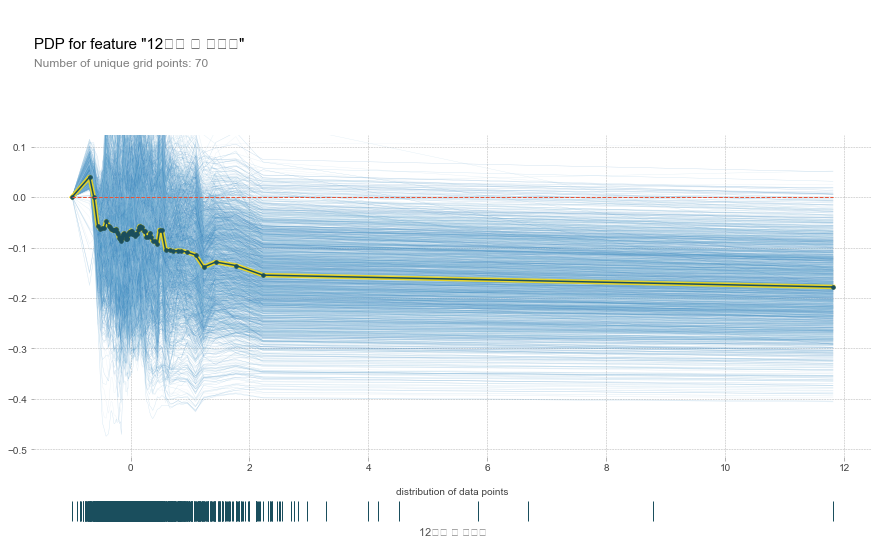

KOSPI대비 12개월 간 수익률 PDP


<Figure size 432x288 with 0 Axes>

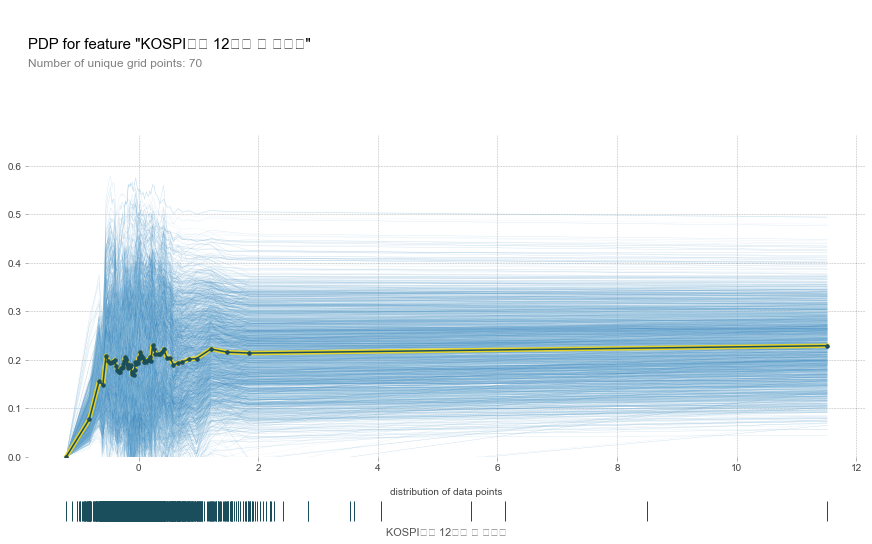

PER_inv PDP


<Figure size 432x288 with 0 Axes>

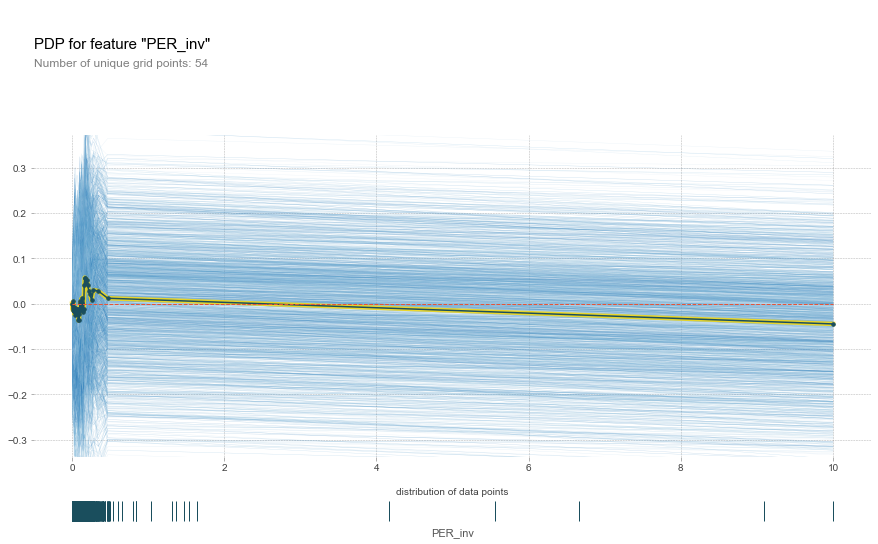

PBR_inv PDP


<Figure size 432x288 with 0 Axes>

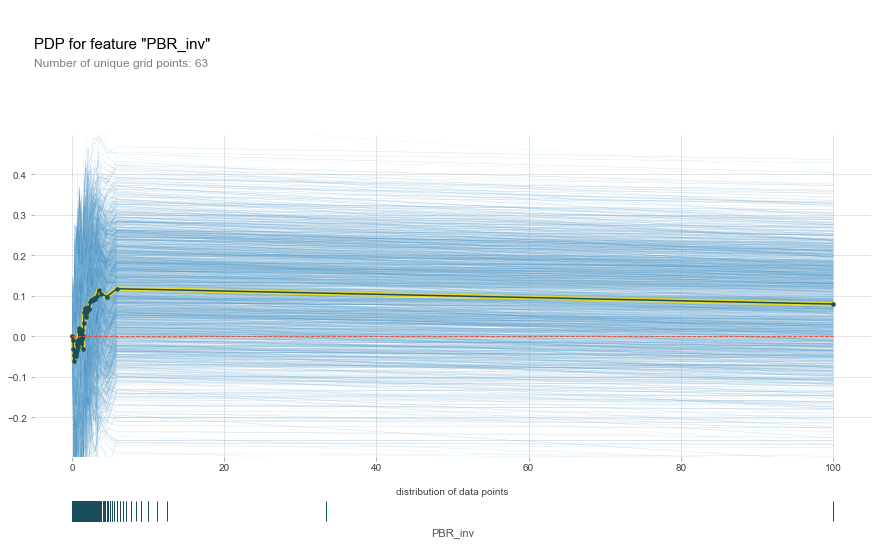

배당수익률 PDP


<Figure size 432x288 with 0 Axes>

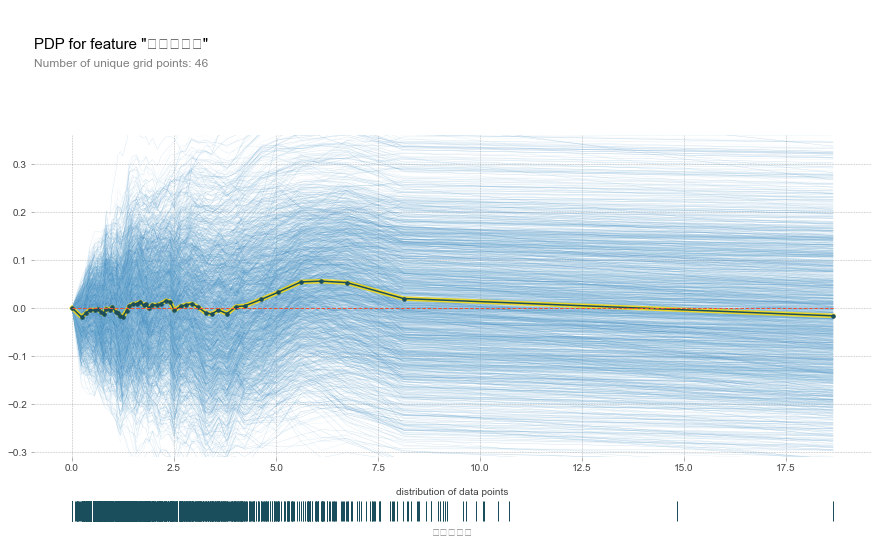

In [369]:
from pdpbox.pdp import pdp_isolate, pdp_plot

for feat in X_train.columns[[0, 1, 3, 4, 5]]:
    feature = feat
    isolated = pdp_isolate(
        model=best_model,
        dataset=X_test,
        model_features=X_test.columns,
        feature = feature,
        grid_type='percentile', # 다른 option으로 'equal'이 있음
        num_grid_points=70,
    )
    print('{} PDP'.format(feat))
    plt.figure();
    pdp_plot(isolated, feature_name=feature, plot_lines=True, plot_pts_dist=True);
    plt.show();

## 3) SHAP Values

In [380]:
import shap

explainer = shap.TreeExplainer(best_model.named_steps['randomforestclassifier'])

how_many = 100

shap_values = explainer.shap_values(X_test.iloc[:how_many])

### Draw SHAP plots ###
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_values[1],
    features=X_test.iloc[:how_many]  # 샘플의 피쳐 값을 넣어줌
)

# 5. 결론
- 1년동안 많이 올랐으면 다음에도 많이 안 오를 수 있다.
- KOSPI가 떨어질 때 오르거나 유지한(코스피를 이긴) 종목이 진짜다.
- 역시 PBR, PER가 낮을 수록 좋다. 특히 PBR이 더 큰 영향.

#### *현재 기준 1년간 수익률, PER, PBR, 배당수익률을 바탕으로  6개월 뒤 KOSPI보다 오를 주식을 어느 정도 찾을 수 있다.*

# 6. 한계점
- 추가적인 Feature Engineering을 통해 모델 성능을 향상시킬 여지가 매우 많으나, 시간이 부족해 하지 못했다.
- 데이터 누수를 피하기 위해 2003년의 시가총액 상위 기업들만 대상으로 분석을 진행해 신규 회사들을 학습, 예측하지 못했다.
- 모델의 성능을 dramatic하게 올리진 못했으며, threshold 조정에 따른 precision score의 편차가 커서 일반화하기 어렵다.

n과 m이 높을수록 정확도가 높아지는 경향이 있는 것으로 보인다.

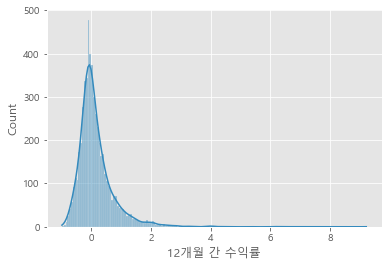

In [146]:
sns.histplot(X[f'{n}개월 간 수익률'], kde=True);

In [147]:
X.columns

Index(['12개월 간 수익률', 'KOSPI대비 12개월 간 수익률', '12개월 간 KOSPI 이김', 'PER', 'PBR',
       '배당수익률'],
      dtype='object')

In [19]:
data.sort_values(by=X.columns[0]).tail(20)

,date,code,6개월 간 수익률,3개월 후 수익률,name,KOSPI 6개월 간 수익률,KOSPI 3개월 후 수익률,KOSPI대비 6개월 간 수익률,KOSPI대비 3개월 후 수익률,6개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률
332,2010-12-28,067250,1.171063,-0.050499,STX조선해양,0.205831,0.011346,0.965233,-0.061845,1,0,0.00,1.56,0.82
2814,2017-07-01,005880,1.185304,-0.051967,대한해운,0.180455,-0.000004,1.004849,-0.051963,1,0,10.54,0.73,0.00
1974,2015-07-01,004800,1.198217,-0.230510,효성,0.088998,-0.073903,1.109219,-0.156607,1,0,0.00,0.91,1.49
3955,2020-12-27,044490,1.211094,-0.134948,태웅,0.331319,0.082749,0.879775,-0.217698,1,0,0.00,0.55,0.00
549,2011-07-01,002350,1.296820,-0.035897,넥센타이어,0.026888,-0.167683,1.269932,0.131785,1,1,6.96,2.11,0.71
3890,2020-12-27,010060,1.332432,0.355311,OCI,0.331319,0.082749,1.001113,0.272562,1,1,0.00,0.89,0.00
3930,2020-12-27,009830,1.371456,0.092333,한화석화,0.331319,0.082749,1.040137,0.009584,1,1,0.00,1.40,0.41
2035,2015-07-01,036490,1.414953,-0.282508,소디프신소재,0.088998,-0.073903,1.325955,-0.208605,1,0,1621.21,1.78,0.93
3961,2020-12-27,006280,1.456081,0.008475,녹십자,0.331319,0.082749,1.124762,-0.074275,1,0,0.00,5.29,0.21
157,2010-07-01,020560,1.523018,-0.036470,아시아나항공,-0.005837,0.106871,1.528854,-0.143341,1,0,0.00,0.85,0.00


```python
import FinanceDataReader as fdr

# Apple(AAPL), 2017-01-01 ~ Now
df = fdr.DataReader('AAPL', '2017')

# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
df = fdr.DataReader('F', '1980-01-01', '2019-12-30')

# AMAZON(AMZN), 2017
df = fdr.DataReader('AMZN', '2017-01-01', '2019-12-31')

# Samsung(005930), 1992-01-01 ~ 2018-10-31
df = fdr.DataReader('068270', '1992-01-01', '2019-10-31')

# country code: ex) 000150: Doosan(KR), Yihua Healthcare(CN)
df = fdr.DataReader('000150', '2018-01-01', '2019-10-30') # KRX
df = fdr.DataReader('000150', '2018-01-01', '2019-10-30', exchange='KRX') # KRX
df = fdr.DataReader('000150', '2018-01-01', '2019-10-30', exchange='SZSE') # SZSE
df = fdr.DataReader('000150', '2018-01-01', '2019-10-30', exchange='심천') # SZSE

# KRX delisting stock data 상장폐지 종목 데이터 (상장일~상장폐지일)
df = fdr.DataReader('036360', exchange='krx-delisting')

# KOSPI index, 2015 ~ Now
ks11 = fdr.DataReader('KS11', '2015-01-01')

# Dow Jones Industrial(DJI), 2015 ~ Now
dji = fdr.DataReader('DJI', '2015-01-01')

# USD/KRW, 1995~Now
usdkrw = fdr.DataReader('USD/KRW', '1995-01-01')

# Bitcoin KRW price (Bithumbs), 2016 ~ Now
# btc = fdr.DataReader('BTC/KRW', '2016-01-01')

# KRX stock symbol list and names
krx = fdr.StockListing('KRX')

# KRX stock delisting symbol list and names 상장폐지 종목 전체 리스트
krx_delisting = fdr.StockListing('KRX-DELISTING')

# S&P 500 symbol list
sp500 = fdr.StockListing('S&P500')
```

``` python
import dart_fss as dart

# Open DART API KEY 설정
api_key = '88ff711a635ea2b0ae522827aa8d310ef262aec1'
dart.set_api_key(api_key=api_key)

# DART 에 공시된 회사 리스트 불러오기
corp_list = dart.get_corp_list()

# 삼성전자 검색
samsung = corp_list.find_by_corp_name('삼성전자', exactly=True)[0]

# 2012년부터 연간 연결재무제표 불러오기
fs = samsung.extract_fs(bgn_de='20120101')

# 재무제표 검색 결과를 엑셀파일로 저장 ( 기본저장위치: 실행폴더/fsdata )
fs.save()
```

```python
import dart_fss as dart

api_key = '88ff711a635ea2b0ae522827aa8d310ef262aec1'
dart.set_api_key(api_key=api_key)

corp_list = dart.get_corp_list()

samsung = corp_list.find_by_corp_name('삼성전자', exactly=True)[0]
fs = samsung.extract_fs(bgn_de='20210301')
fs.labels.keys()
fs['cf']
```

# 코드 무덤

In [ ]:
# def nearest_date(target_date, date_list, lower=True):
#     '''target_date와 가장 가까운 date를 date_list에서 찾아준다.
#     target_date는 2017-01-02 또는 20170102와 같은 양식으로 넣도록 한다.'''
    
#     if target_date in date_list:
#         return target_date
    
#     if lower:
#         while True:
        
#     else: # higher
        
# 생각해보니 부등호로 해결하면 될듯..^^

In [ ]:
# n = 3 # n개월 간의 주가 추이 확인
# m = 1 # m개월 후의 수익률 확인

# def ER_list_return(stock_price, n=n, m=m, date_list=date_list):
#     '''stock_price정보를 가지고 base_date 기준 n개월 전, m개월 후 수익률을 구해준다.
#     return : 데이터로 사용할 수익률, target을 구할 때 사용할 수익률, base_date'''
#     earning_rate_list = []
#     target_list = []
#     base_date_list = []  # 수익률 기준일
    
#     for date in date_list:
#         date_after_n_month = date_add(date, n)
#         date_after_2n_month = date_add(date_after_n_month, n)
# #         print(date_after_n_month, date_after_2n_month)
#         try:
#             er1 = earning_rate(stock_price, date, date_after_n_month)
#             er2 = earning_rate(stock_price, date_after_n_month, date_after_2n_month)
#             er3 = earning_rate(stock_price, date_after_n_month, date_add(date_after_n_month, m))
#             er4 = earning_rate(stock_price, date_after_2n_month, date_add(date_after_2n_month, m))
            
#             earning_rate_list.append(er1)
#             earning_rate_list.append(er2)
#             target_list.append(er3)
#             target_list.append(er4)
#             base_date_list.append(date_after_n_month)
#             base_date_list.append(date_after_2n_month)
            
#         except: # 종목코드가 바뀌거나 상장폐지돼서 주가 데이터가 없는 경우가 있는 것 같음. 이를 고려             
#             break

#     return earning_rate_list, target_list, base_date_list


# # DataFrame 만들기 위해 모든 종목들에 대해 시행해주기
# n_month_ER_data = []
# m_month_ER_data = []
# date_data = []
# code_data = []

# for code in top_code:
#     stock_price = stock_price_dic[code]
#     earning_rate_list, target_list, base_date_list = ER_list_return(stock_price)
#     n_month_ER_data += earning_rate_list
#     m_month_ER_data += target_list
#     date_data += base_date_list
#     code_data += [code]*len(base_date_list)  


In [ ]:
# threshold = 0.6
# y_pred_thres = np.array(list(map(lambda x: 0 if x < threshold else 1, y_proba)))

# print('Baseline model acc score : {:.4f}'.format(accuracy_score(y_test, baseline_model)))
# print('Test set acc score : {:.4f}'.format(pipe.score(X_test, y_test)))
# print('Cross Vlidation Precision score : {:.4f}'.format(cross_val_score(pipe, X.values, y.values.ravel(), cv=5, scoring='precision').mean()))
# # RF에서 feature name에 한글이 들어가면 warning이 뜨는 것 같기도 함. 그리고 왠지는 모르곘지만 넣는 형식도 바꿔줬음

# print()
# print('Precision score of  : {:.4f}'.format(precision_score(y_test, [1]*len(y_test))))
# print('Precision score of Test set : {:.4f}'.format(precision_score(y_test, y_pred)))
# print('Precision score of Test set with threshold adjusted : {:.4f}'.format(precision_score(y_test, y_pred_thres)))

## Target
- 현재 시점 기준 특정 종목의 m개월 뒤 수익률이 KOSPI보다 높을 것인가(이진 분류)

### 가설!
- 시간에 관계 없이 주가의 추이, 거래정보, 종목의 정보 등과 수익률 사이에는 관계가 있다.

## Feature Engineering Idea
1. 최근 n개월(n일) 수익률
2. 코스피 최근 n개월 코스피대비 상승한 정도
3. 최근 n개월 누적 '고가-저가' 퍼센티지(변동성 의미)
4. 시가총액 순위
5. 누적거래대금/시가총액

## 데이터는 어떻게 불리지?
- 연도별로 데이터를 나누어서 불린다!

### 시간이 나면 해볼 일, 고려해봐야 할 것
- Feature 늘려서 성능 높이기
    - 재무제표 추가
    - 시가총액 추가
- 몇월을 기준으로 데이터를 끊어서 학습하느냐에 따라 결과가 달라질 수도 있지 않을까?